In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:34<00:00, 4.97MB/s]


In [5]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 79.0MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1)

In [7]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, desc="Training")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss / len(trainloader), 100. * correct / total

def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return 100. * correct / total

In [8]:
for epoch in range(1):
    print(f"\nEpoch {epoch+1}/1:")
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_acc = evaluate(model, testloader, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


torch.save(model.state_dict(), 'resnet18_cifar10_finetuned.pth')


Epoch 1/1:


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Train Loss: 0.378 | Train Acc: 87.14% | Test Acc: 91.98%


In [9]:
middle_layer_weights = None
final_layer_weights = None

for name, module in model.named_modules():
    if name == 'layer3.1.conv2':
        middle_layer_weights = module.weight.data.cpu().numpy()
        print(f"Middle layer: {name}, shape: {middle_layer_weights.shape}")
    elif name == 'fc':
        final_layer_weights = module.weight.data.cpu().numpy()
        print(f"Final layer: {name}, shape: {final_layer_weights.shape}")

Middle layer: layer3.1.conv2, shape: (256, 256, 3, 3)
Final layer: fc, shape: (10, 512)


In [10]:
def analyze_svd(weights, layer_name):
    original_shape = weights.shape
    if len(weights.shape) == 4:
        weights_2d = weights.reshape(weights.shape[0], -1)
    else:
        weights_2d = weights

    U, S, Vt = np.linalg.svd(weights_2d, full_matrices=False)

    variance_explained = np.cumsum(S**2) / np.sum(S**2) * 100

    k_95 = np.argmax(variance_explained >= 95) + 1
    total_singular_values = len(S)
    percentage_95 = (k_95 / total_singular_values) * 100

    print(f"\n{layer_name}:")
    print(f"  - Total singular values: {total_singular_values}")
    print(f"  - Singular values for 95% variance: {k_95} ({percentage_95:.2f}%)")
    print(f"  - Top 10 singular values: {S[:10]}")

    return S, variance_explained, k_95, percentage_95

In [11]:
S_middle, var_middle, k95_middle, pct95_middle = analyze_svd(
    middle_layer_weights, "Middle Layer (layer3.1.conv2)"
)

S_final, var_final, k95_final, pct95_final = analyze_svd(
    final_layer_weights, "Final Layer (fc)"
)


Middle Layer (layer3.1.conv2):
  - Total singular values: 256
  - Singular values for 95% variance: 199 (77.73%)
  - Top 10 singular values: [3.5928478 2.3695471 2.1202645 2.0906062 1.9624658 1.9167655 1.9072722
 1.8784195 1.7908012 1.7769382]

Final Layer (fc):
  - Total singular values: 10
  - Singular values for 95% variance: 9 (90.00%)
  - Top 10 singular values: [1.3065312  1.0849106  1.0570822  0.99150044 0.9574469  0.93170893
 0.85138845 0.8375287  0.7683768  0.5902153 ]


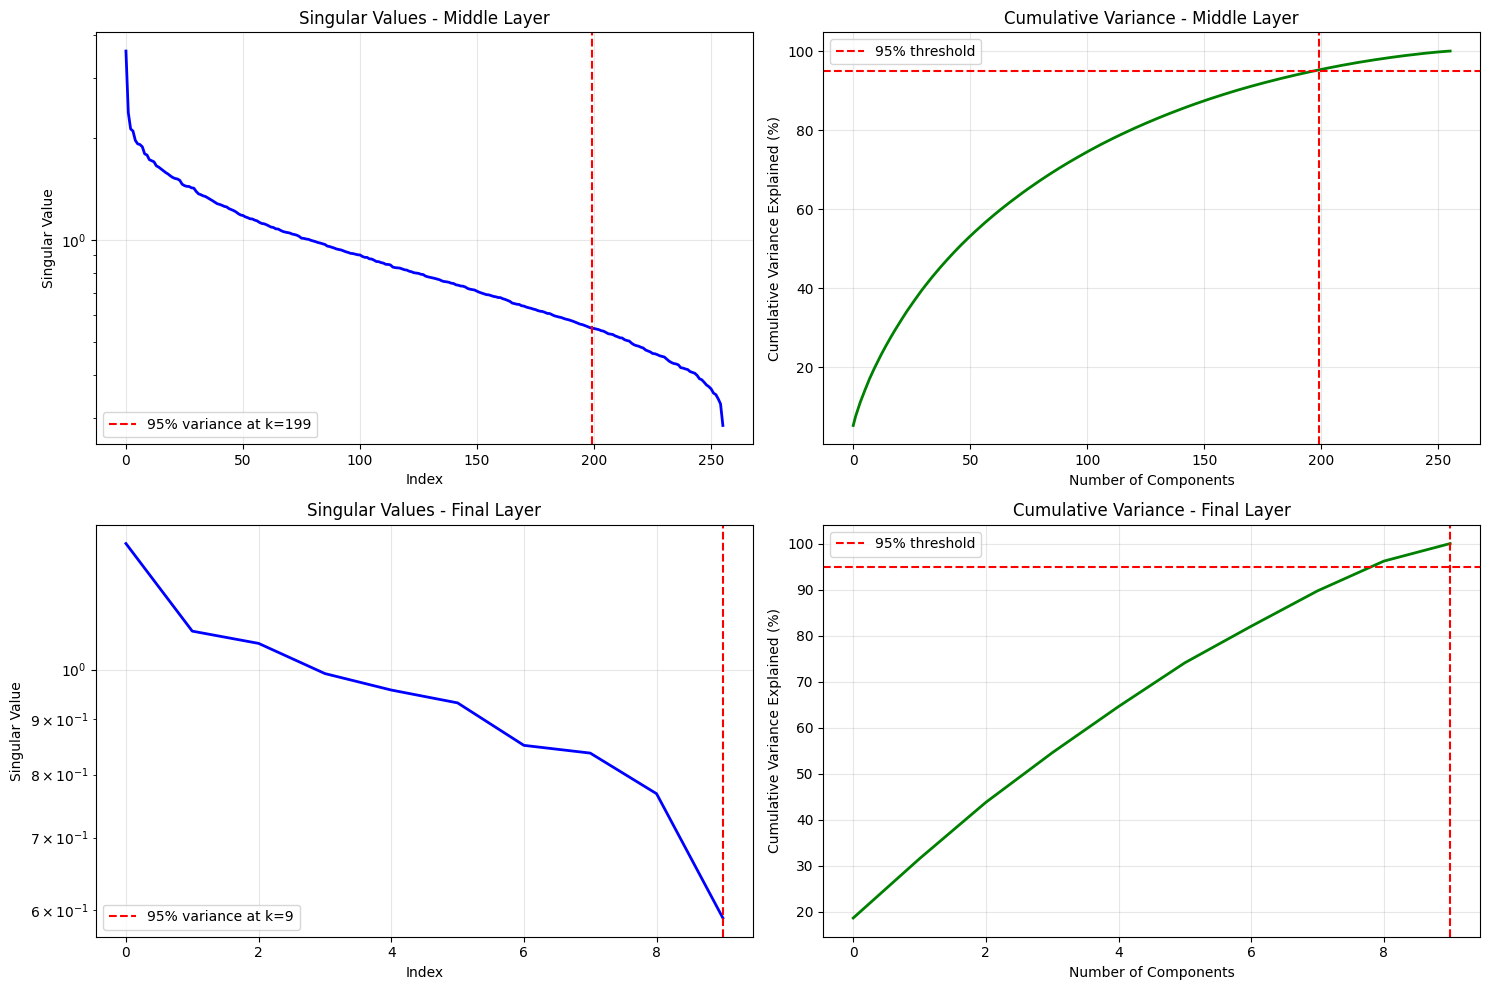

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Graph 1: Singular values - middle layer
axes[0, 0].plot(S_middle, 'b-', linewidth=2)
axes[0, 0].axvline(x=k95_middle, color='r', linestyle='--',
                    label=f'95% variance at k={k95_middle}')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Singular Value')
axes[0, 0].set_title('Singular Values - Middle Layer')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Graph 2: Cumulative variance - middle layer
axes[0, 1].plot(var_middle, 'g-', linewidth=2)
axes[0, 1].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[0, 1].axvline(x=k95_middle, color='r', linestyle='--')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance Explained (%)')
axes[0, 1].set_title('Cumulative Variance - Middle Layer')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graph 3: Singular values - final layer
axes[1, 0].plot(S_final, 'b-', linewidth=2)
axes[1, 0].axvline(x=k95_final, color='r', linestyle='--',
                    label=f'95% variance at k={k95_final}')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Singular Value')
axes[1, 0].set_title('Singular Values - Final Layer')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Graph 4: Cumulative variance - final layer
axes[1, 1].plot(var_final, 'g-', linewidth=2)
axes[1, 1].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[1, 1].axvline(x=k95_final, color='r', linestyle='--')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Cumulative Variance Explained (%)')
axes[1, 1].set_title('Cumulative Variance - Final Layer')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svd_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
class LowRankLinear(nn.Module):
    def __init__(self, in_features, out_features, rank):
        super(LowRankLinear, self).__init__()
        self.layer1 = nn.Linear(in_features, rank, bias=False)
        self.layer2 = nn.Linear(rank, out_features, bias=True)

    def forward(self, x):
        return self.layer2(self.layer1(x))

def compress_linear_layer(layer, compression_ratio):

    weight = layer.weight.data.cpu().numpy()
    bias = layer.bias.data.cpu().numpy() if layer.bias is not None else None

    # Calculate SVD
    U, S, Vt = np.linalg.svd(weight, full_matrices=False)

    # Determine rank based on compression ratio
    original_rank = len(S)
    new_rank = max(1, int(original_rank * (1 - compression_ratio)))

    # Create compressed matrices
    U_compressed = U[:, :new_rank]
    S_compressed = S[:new_rank]
    Vt_compressed = Vt[:new_rank, :]

    # Create new layer
    compressed_layer = LowRankLinear(layer.in_features, layer.out_features, new_rank)

    # Initialize weights
    compressed_layer.layer1.weight.data = torch.from_numpy(
        (np.diag(np.sqrt(S_compressed)) @ Vt_compressed).astype(np.float32)
    )
    compressed_layer.layer2.weight.data = torch.from_numpy(
        (U_compressed @ np.diag(np.sqrt(S_compressed))).astype(np.float32)
    )

    if bias is not None:
        compressed_layer.layer2.bias.data = torch.from_numpy(bias.astype(np.float32))

    return compressed_layer, new_rank, original_rank

In [14]:
def compress_model(model, compression_ratio):
    compressed_model = deepcopy(model)
    compression_info = []

    for name, module in compressed_model.named_modules():
        if isinstance(module, nn.Linear) and 'fc' in name:

            parent_name = '.'.join(name.split('.')[:-1])
            child_name = name.split('.')[-1]

            if parent_name:
                parent = dict(compressed_model.named_modules())[parent_name]
            else:
                parent = compressed_model

            compressed_layer, new_rank, orig_rank = compress_linear_layer(
                module, compression_ratio
            )
            setattr(parent, child_name, compressed_layer)

            compression_info.append({
                'layer': name,
                'original_rank': orig_rank,
                'compressed_rank': new_rank,
                'compression': f"{(1 - new_rank/orig_rank)*100:.1f}%"
            })

    return compressed_model, compression_info

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [16]:
model_original = deepcopy(model)
params_original = count_parameters(model_original)
acc_original = evaluate(model_original, testloader, device)

print(f"\nOriginal Model:")
print(f"  - Parameters: {params_original:,}")
print(f"  - Accuracy: {acc_original:.2f}%")

Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


Original Model:
  - Parameters: 11,181,642
  - Accuracy: 91.98%


In [17]:
model_50, info_50 = compress_model(model, 0.50)
model_50 = model_50.to(device)
params_50 = count_parameters(model_50)
acc_50 = evaluate(model_50, testloader, device)
print(f"\n50% Compressed Model:")
print(f"  - Parameters: {params_50:,}")
print(f"  - Accuracy: {acc_50:.2f}%")
print(f"  - Parameter reduction: {(1 - params_50/params_original)*100:.2f}%")

Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


50% Compressed Model:
  - Parameters: 11,179,132
  - Accuracy: 79.14%
  - Parameter reduction: 0.02%


In [18]:
model_80, info_80 = compress_model(model, 0.80)
model_80 = model_80.to(device)
params_80 = count_parameters(model_80)
acc_80 = evaluate(model_80, testloader, device)
print(f"\n80% Compressed Model:")
print(f"  - Parameters: {params_80:,}")
print(f"  - Accuracy: {acc_80:.2f}%")
print(f"  - Parameter reduction: {(1 - params_80/params_original)*100:.2f}%")

Evaluating: 100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


80% Compressed Model:
  - Parameters: 11,177,044
  - Accuracy: 20.08%
  - Parameter reduction: 0.04%


In [19]:
print(f"{'Model':<20} {'Parameters':<20} {'Accuracy (%)':<15} {'Parameter Reduction (%)':<25}")
print("-" * 80)
print(f"{'Original':<20} {params_original:<20,} {acc_original:<15.2f} {'-':<25}")
print(f"{'Compressed 50%':<20} {params_50:<20,} {acc_50:<15.2f} {(1-params_50/params_original)*100:<25.2f}")
print(f"{'Compressed 80%':<20} {params_80:<20,} {acc_80:<15.2f} {(1-params_80/params_original)*100:<25.2f}")

Model                Parameters           Accuracy (%)    Parameter Reduction (%)  
--------------------------------------------------------------------------------
Original             11,181,642           91.98           -                        
Compressed 50%       11,179,132           79.14           0.02                     
Compressed 80%       11,177,044           20.08           0.04                     


In [20]:
def finetune_model(model, trainloader, testloader, epochs=3):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    history = {'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}:")
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        test_acc = evaluate(model, testloader, device)
        scheduler.step()

        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    return history

In [21]:
history_50 = finetune_model(model_50, trainloader, testloader, epochs=3)
acc_50_finetuned = history_50['test_acc'][-1]


Epoch 1/3:


Evaluating: 100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Train Loss: 0.273 | Train Acc: 90.95% | Test Acc: 92.62%

Epoch 2/3:


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


Train Loss: 0.176 | Train Acc: 94.35% | Test Acc: 93.38%

Epoch 3/3:


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]

Train Loss: 0.153 | Train Acc: 94.99% | Test Acc: 93.74%


In [22]:
history_80 = finetune_model(model_80, trainloader, testloader, epochs=3)
acc_80_finetuned = history_80['test_acc'][-1]


Epoch 1/3:


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.39it/s]


Train Loss: 1.614 | Train Acc: 21.19% | Test Acc: 22.07%

Epoch 2/3:


Evaluating: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


Train Loss: 1.504 | Train Acc: 25.97% | Test Acc: 27.06%

Epoch 3/3:


Evaluating: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]

Train Loss: 1.453 | Train Acc: 30.78% | Test Acc: 29.91%


In [23]:
print(f"{'Model':<20} {'Before (%)':<20} {'After (%)':<20} {'Improvement (%)':<15}")
print("-" * 75)
print(f"{'Compressed 50%':<20} {acc_50:<20.2f} {acc_50_finetuned:<20.2f} {acc_50_finetuned-acc_50:<15.2f}")
print(f"{'Compressed 80%':<20} {acc_80:<20.2f} {acc_80_finetuned:<20.2f} {acc_80_finetuned-acc_80:<15.2f}")

Model                Before (%)           After (%)            Improvement (%)
---------------------------------------------------------------------------
Compressed 50%       79.14                93.74                14.60          
Compressed 80%       20.08                29.91                9.83           


In [24]:
def measure_inference_speed(model, num_iterations=100):
    model.eval()
    model.cpu()

    # Create random input
    dummy_input = torch.randn(1, 3, 224, 224)

    # Warm-up
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)

    # Measure time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)
    end_time = time.time()

    avg_time = (end_time - start_time) / num_iterations * 1000  # ms
    model.to(device)

    return avg_time

In [25]:
speed_original = measure_inference_speed(model_original)
speed_50 = measure_inference_speed(model_50)
speed_80 = measure_inference_speed(model_80)

In [26]:
print(f"\n{'Model':<20} {'Inference Time (ms)':<25} {'Relative Speed':<20}")
print("-" * 65)
print(f"{'Original':<20} {speed_original:<25.2f} {'1.00x':<20}")
print(f"{'Compressed 50%':<20} {speed_50:<25.2f} {speed_original/speed_50:<20.2f}x")
print(f"{'Compressed 80%':<20} {speed_80:<25.2f} {speed_original/speed_80:<20.2f}x")


Model                Inference Time (ms)       Relative Speed      
-----------------------------------------------------------------
Original             57.19                     1.00x               
Compressed 50%       63.64                     0.90                x
Compressed 80%       55.71                     1.03                x


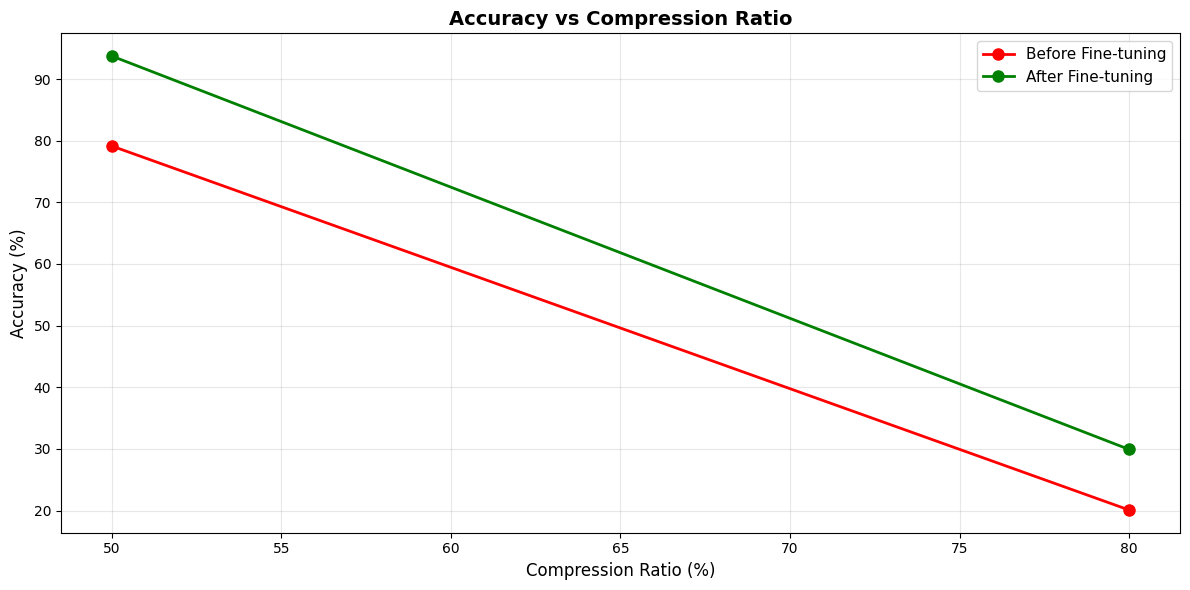

In [27]:
compression_ratios = [50, 80]

accuracies_before = [acc_50, acc_80]
accuracies_after = [acc_50_finetuned, acc_80_finetuned]

plt.figure(figsize=(12, 6))

plt.plot(compression_ratios, accuracies_before,
         'ro-', linewidth=2, markersize=8, label='Before Fine-tuning')

plt.plot(compression_ratios, accuracies_after,
         'go-', linewidth=2, markersize=8, label='After Fine-tuning')

plt.xlabel('Compression Ratio (%)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy vs Compression Ratio', fontsize=14, fontweight='bold')

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('accuracy_vs_compression.png', dpi=300, bbox_inches='tight')

plt.show()
